In [1]:
import pyerrors as pe
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('./base_style.mplstyle')
plt.rc('text', usetex=True)

Read data from the pcac example

In [3]:
p_obs = {}
p_obs['f_P'] = pe.load_object('./data/B1k2_f_P.p')

# f_A can be accesed via p_obs['f_A']

[o.gamma_method() for o in p_obs['f_P']];

We can now define a custom fit function, in this case a single exponential. __Here we need to use the autograd wrapped version of numpy__  (imported as anp) to use automatic differentiation.

In [4]:
import autograd.numpy as anp
def func_exp(a, x):
    y = a[1] * anp.exp(-a[0] * x)
    return y

Fit single exponential to f_P. The kwarg `resplot` generates a figure which visualizes the fit with residuals.

Fit with 2 parameters
Method: Levenberg-Marquardt
`xtol` termination condition is satisfied.
chisquare/d.o.f.: 0.00287692704517733


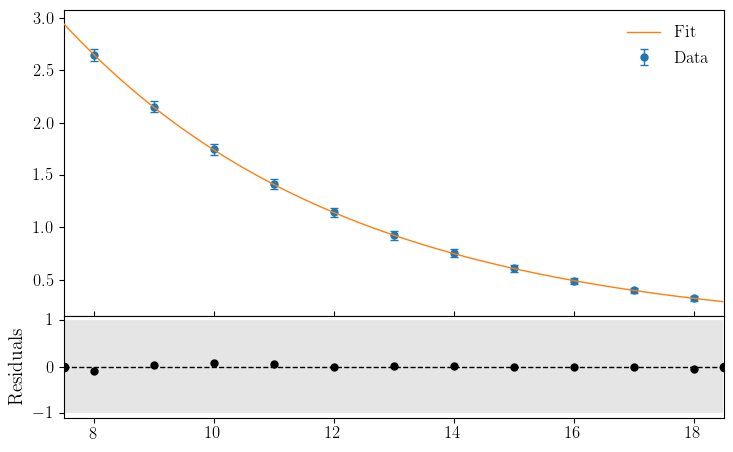

Mass, Matrix element:
[Obs[0.2102(63)], Obs[14.24(66)]]


In [5]:
# Specify fit range for single exponential fit
start_se = 8
stop_se = 19

a = pe.fits.standard_fit(np.arange(start_se, stop_se), p_obs['f_P'][start_se:stop_se], func_exp, resplot=True)
[o.gamma_method() for o in a]
print('Mass, Matrix element:')
print(a)

The covariance of the two fit parameters can be computed in the following way

In [6]:
cov_01 = pe.fits.covariance(a[0], a[1])
print('Covariance: ', cov_01)
print('Normalized covariance: ', cov_01 / a[0].dvalue / a[1].dvalue)

Covariance:  0.003465486601483565
Normalized covariance:  0.8360758153764554


## Effective mass

Calculate the effective mass for comparison

In [7]:
m_eff_f_P = []
for i in range(len(p_obs['f_P']) - 1):
    m_eff_f_P.append(np.log(p_obs['f_P'][i] / p_obs['f_P'][i+1]))
    m_eff_f_P[i].gamma_method()

Calculate the corresponding plateau and compare the two results

In [8]:
m_eff_plateau = np.mean(m_eff_f_P[start_se: stop_se]) # Plateau from 8 to 16
m_eff_plateau.gamma_method()
print('Effective mass:')
m_eff_plateau.print(0)
print('Fitted mass:')
a[0].print(0)

Effective mass:
Obs[0.2114(52)]
Fitted mass:
Obs[0.2102(63)]


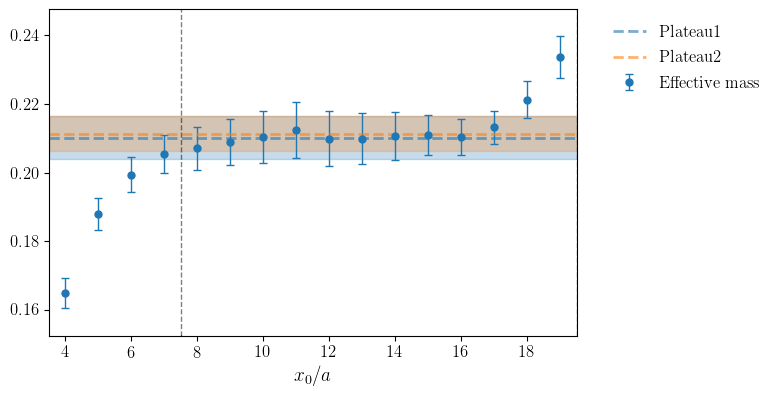

In [9]:
pe.plot_corrs([m_eff_f_P], plateau=[a[0], m_eff_plateau], xrange=[3.5, 19.5], prange=[start_se, stop_se], label=['Effective mass'])

## Fitting two exponentials

We can also fit the data with two exponentials where the second term describes the cutoff effects imposed by the boundary.

In [10]:
def func_2exp(a, x):
    y = a[1] * anp.exp(-a[0] * x) + a[3] * anp.exp(-a[2] * x)
    return y

We can trigger the computation of $\chi^2/\chi^2_\text{exp}$ with the kwarg `expected_chisquare` which takes into account correlations in the data and non-linearities in the fit function and should give a more reliable measure for goodness of fit than $\chi^2/\text{d.o.f.}$.

Fit with 4 parameters
Method: Levenberg-Marquardt
`xtol` termination condition is satisfied.
chisquare/d.o.f.: 0.05399877210985092
chisquare/expected_chisquare: 0.7915235152330492


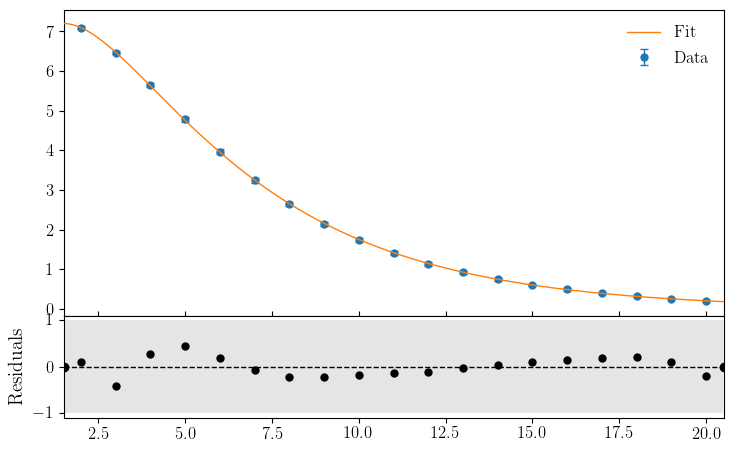

Fit result:
[Obs[0.2146(65)], Obs[15.15(88)], Obs[0.623(60)], Obs[-9.64(74)]]


In [11]:
# Specify fit range for double exponential fit
start_de = 2
stop_de = 21

a = pe.fits.standard_fit(np.arange(start_de, stop_de), p_obs['f_P'][start_de:stop_de], func_2exp, initial_guess=[0.21, 14.0, 0.6, -10], resplot=True, expected_chisquare=True)
[o.gamma_method() for o in a]
print('Fit result:')
print(a)

## Fitting with x-errors

We first generate pseudo data

In [12]:
ox = []
oy = []
for i in range(0,10,2):
    ox.append(pe.pseudo_Obs(i + 0.35 * np.random.normal(), 0.35, str(i)))
    oy.append(pe.pseudo_Obs(np.sin(i) + 0.25 * np.random.normal() - 0.2 * i + 0.17, 0.25, str(i)))

[o.gamma_method() for o in ox + oy]
[print(o) for o in zip(ox, oy)];

(Obs[-0.08(35)], Obs[0.19(25)])
(Obs[1.85(35)], Obs[0.34(25)])
(Obs[4.01(35)], Obs[-1.39(25)])
(Obs[6.10(35)], Obs[-1.30(25)])
(Obs[8.08(35)], Obs[-0.37(25)])


And choose a function to fit

In [13]:
def func(a, x):
    y = a[0] + a[1] * x + a[2] * anp.sin(x)
    return y

We can then fit this function to the data and get the fit parameter as Obs with the function `odr_fit` which uses orthogonal distance regression.

In [14]:
beta = pe.fits.odr_fit(ox, oy, func)

pe.Obs.e_tag_global = 1 # Makes sure that the different samples with name length 1 are treated as ensembles and not as replica

for i, item in enumerate(beta):
    item.gamma_method()
    print('Parameter', i + 1, ':', item)

Fit with 3 parameters
Method: ODR
Sum of squares convergence
Residual variance: 0.5988333933914471
Parameter 1 : Obs[-0.01(29)]
Parameter 2 : Obs[-0.165(55)]
Parameter 3 : Obs[0.89(23)]


For the visulization we determine the value of the fit function in a range of x values

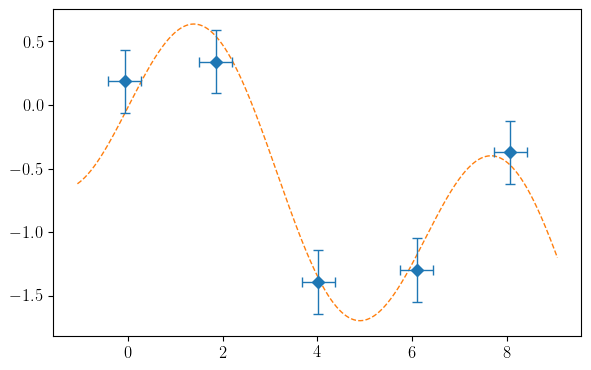

In [15]:
x_t = np.arange(min(ox).value - 1, max(ox).value + 1, 0.01)
y_t = func([o.value for o in beta], x_t)

plt.errorbar([e.value for e in ox], [e.value for e in oy], xerr=[e.dvalue for e in ox], yerr=[e.dvalue for e in oy], marker='D', lw=1, ls='none', zorder=10)
plt.plot(x_t, y_t, '--')
plt.show()

We can also take a look at how much the inidividual ensembles contribute to the uncetainty of the fit parameters

Parameter 0


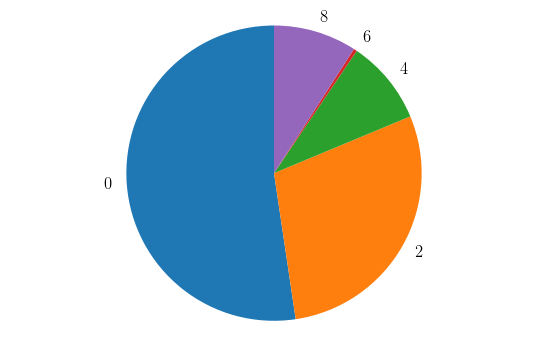


Parameter 1


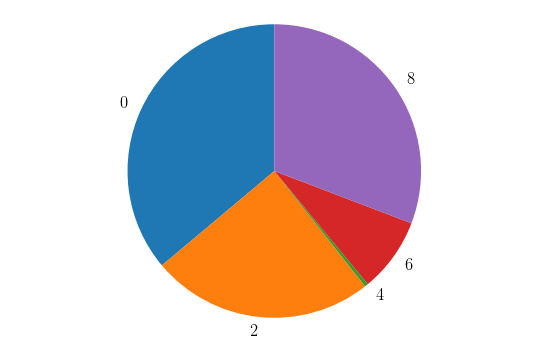


Parameter 2


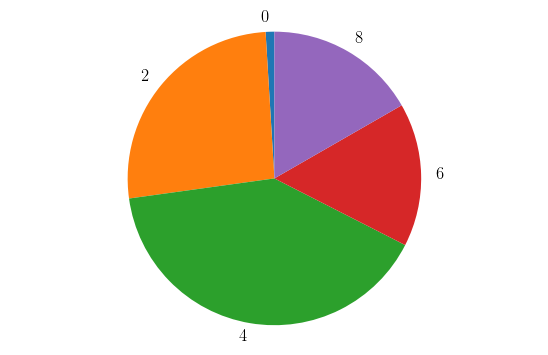

In [16]:
for i, item in enumerate(beta):
    print('Parameter', i)
    item.plot_piechart()
    print()

## Fitting with priors

When extracting energy levels and matrix elements from correlation functions one is interested in using as much data is possible in order to decrease the final error estimate and also have better control over systematic effects from higher states. This can in principle be achieved by fitting a tower of exponentials to the data. However, in practice it can be very difficult to fit a function with 6 or more parameters to noisy data. One way around this is to cnostrain the fit parameters with Bayesian priors. The principle idea is that any parameter which is determined by the data is almost independent of the priors while the additional parameters which would let a standard fit collapse are essentially constrained by the priors.

We first generate fake data as a tower of three exponentials with noise which increases with temporal separation.

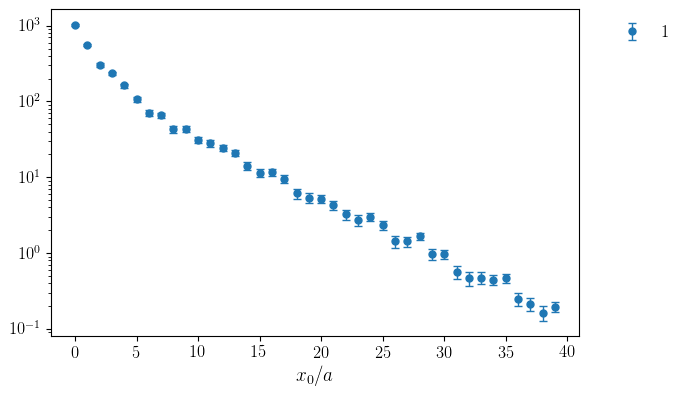

In [17]:
m1 = 0.18
m2 = 0.5
m3 = 0.8

A1 = 180
A2 = 300
A3 = 500

px = []
py = []
for i in range(40):
    px.append(i)
    val = (A1 * np.exp(-m1 * i) + A2 * np.exp(-m2 * i) + A3 * np.exp(-m3 * i))
    err = 0.03 * np.sqrt(i + 1)
    tmp = pe.pseudo_Obs(val * (1 + err * np.random.normal()), val * err, 'e1')
    py.append(tmp)
    
[o.gamma_method() for o in py];

pe.plot_corrs([py], logscale=True)

As fit function we choose the sum of three exponentials

In [18]:
def func_3exp(a, x):
    y = a[1] * anp.exp(-a[0] * x) + a[3] * anp.exp(-a[2] * x) + a[5] * anp.exp(-a[4] * x)
    return y

We can specify the priors in a string format or alternatively input `Obs` from a previous analysis. It is important to choose the priors wide enough, otherwise they can influence the final result.

In [19]:
priors = ['0.2(4)', '200(500)', 
          '0.6(1.2)', '300(550)',
          '0.9(1.8)', '400(700)']

It is important to chose a sufficiently large value of `Obs.e_tag_global`, as every prior is given an ensemble id.

In [20]:
pe.Obs.e_tag_global = 5

The fit can then be performed by calling `prior_fit` which in comparison to the standard fit requires the priors as additional input.

Fit with 6 parameters
Method: migrad
chisquare/d.o.f.: 1.100354109100944


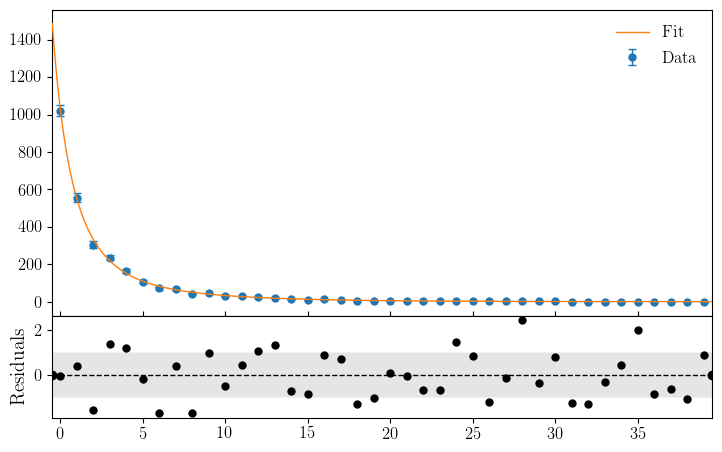

[Obs[0.1795(32)], Obs[186(14)], Obs[0.578(70)], Obs[597(170)], Obs[1.42(83)], Obs[239(173)]]


In [21]:
beta_p = pe.fits.prior_fit(px, py, func_3exp, priors, resplot=True)
[o.gamma_method() for o in beta_p]
print(beta_p)

We can now observe how far the individual fit parameters are constrained by the data or the priors

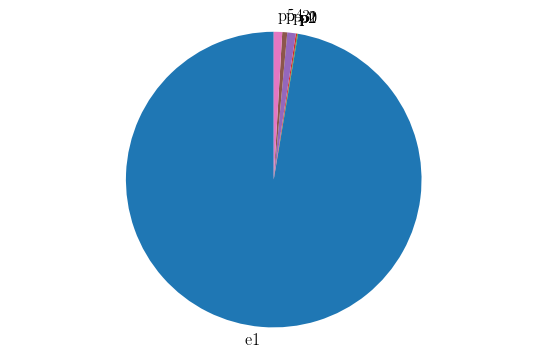

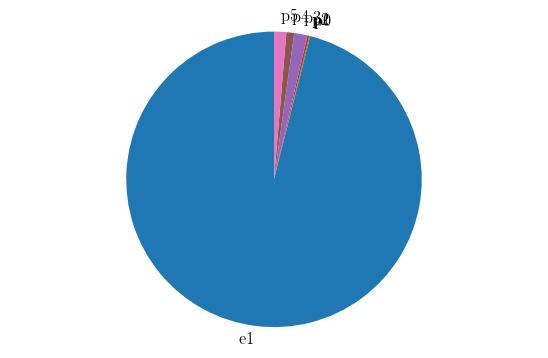

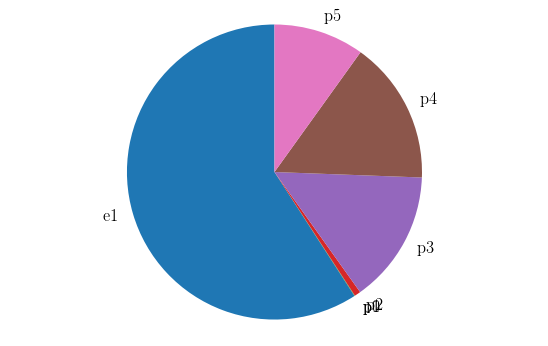

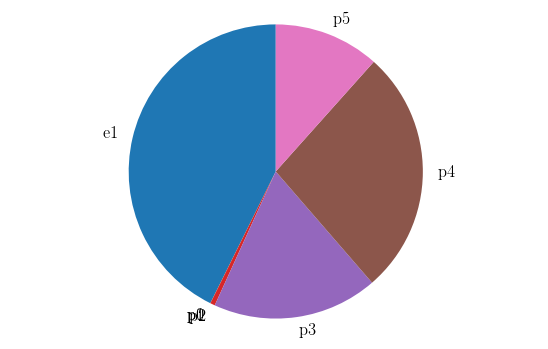

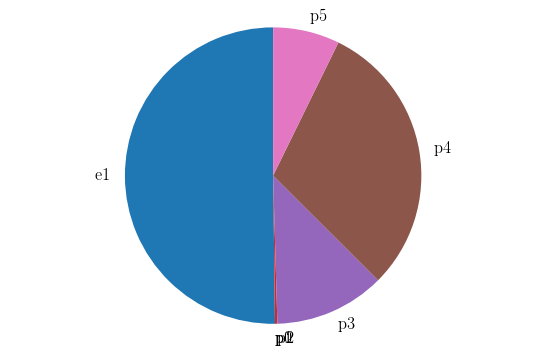

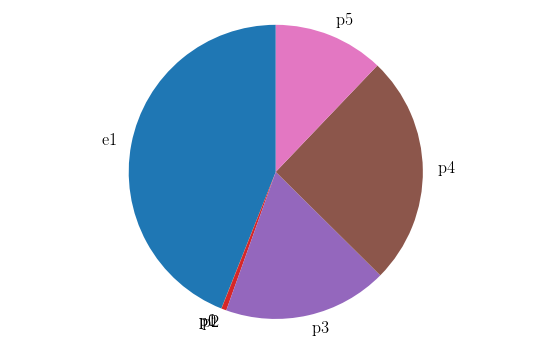

In [22]:
[o.plot_piechart() for o in beta_p];